In [1]:
import itertools
import os

import numpy as np
import pandas as pd
from plotnine import *

In [10]:
fuzzers = ['zest', 'bedivfuzz', 'blind', 'bedivfuzz-h20', 'bedivfuzz-h30', 'bedivfuzz-h50']
subjects = ['ant', 'bcel', 'chocopy', 'closure', 'maven', 'nashorn', 'pngj', 'rhino', 'tomcat']
num_trials = 20
timeout = 180

results_base_dir = 'eval-zeugma-drivers'

In [3]:
def trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-{trial}', 'plot_data'),
        skipinitialspace=True
    )

    # one datapoint per minute
    df = df.loc[np.linspace(0, len(df)-1, timeout, endpoint=True, dtype=np.int64)]
    df['time'] = range(1, timeout+1)
    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject

    return df[['fuzzer', 'subject', 'trial', 'time', 'valid_inputs', 'invalid_inputs', 'unique_paths', 'b0', 'b1', 'b2']]

In [11]:
dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    dfs.append(trial_df(fuzzer=f, subject=s, trial=t))
trials = pd.concat(dfs)

In [12]:
trials.head()

,fuzzer,subject,trial,time,valid_inputs,invalid_inputs,unique_paths,b0,b1,b2
0,zest,ant,1,1,0,23,22,0.0,0.00,0.00
20,zest,ant,1,2,251,13211,7680,10028.0,4166.83,3934.97
40,zest,ant,1,3,964,14970,9420,10505.0,4846.37,4363.76
60,zest,ant,1,4,1626,16485,10985,10521.0,5218.57,4667.78
80,zest,ant,1,5,2404,18072,12633,10521.0,5421.93,4861.35


In [13]:
trials['validity_rate'] = trials['valid_inputs'] / (trials['valid_inputs'] + trials['invalid_inputs'])

In [14]:
mean_trials = trials.groupby(['fuzzer', 'subject', 'time']).agg('mean')

In [15]:
mean_trials

trial  valid_inputs  invalid_inputs  unique_paths  \
fuzzer    subject time                                                      
bedivfuzz ant     1      10.5          0.00           12.95         11.35   
                  2      10.5        140.90        17121.40       8946.25   
                  3      10.5        480.15        24658.55      12339.85   
                  4      10.5        887.60        30850.30      15200.45   
                  5      10.5       1309.90        35944.05      17693.75   
...                       ...           ...             ...           ...   
zest      tomcat  176    10.5     443798.65        63439.45     390884.75   
                  177    10.5     446096.45        63697.60     392731.60   
                  178    10.5     448525.85        63980.90     394735.95   
                  179    10.5     450971.50        64326.95     396681.10   
                  180    10.5     453583.20        64712.65     398886.25   

                             b0         b1         b2  validity_rate  
fuzzer    subject time                                                
bedivfuzz ant     1        0.00     0.0000     0.0000       0.000000  
                  2     8417.80  3989.0145  3857.3620       0.008563  
                  3     8918.55  4475.8470  4138.7885       0.025605  
                  4     9232.10  4776.2805  4365.7880       0.042549  
                  5     9540.10  4979.8360  4536.5170       0.056269  
...                         ...        ...        ...            ...  
zest      tomcat  176   8332.05  5374.6045  5184.2215       0.874593  
                  177   8332.15  5374.3570  5184.0055       0.874713  
                  178   8332.20  5374.1385  5183.8080       0.874828  
                  179   8332.25  5374.1890  5183.8290       0.874803  
                  180   8332.95  5374.1850  5183.8295       0.874782  

[9720 rows x 8 columns]

/Users/lam/_projects/bedivfuzz/.venv/lib/python3.11/site-packages/plotnine/scales/scales.py:48: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



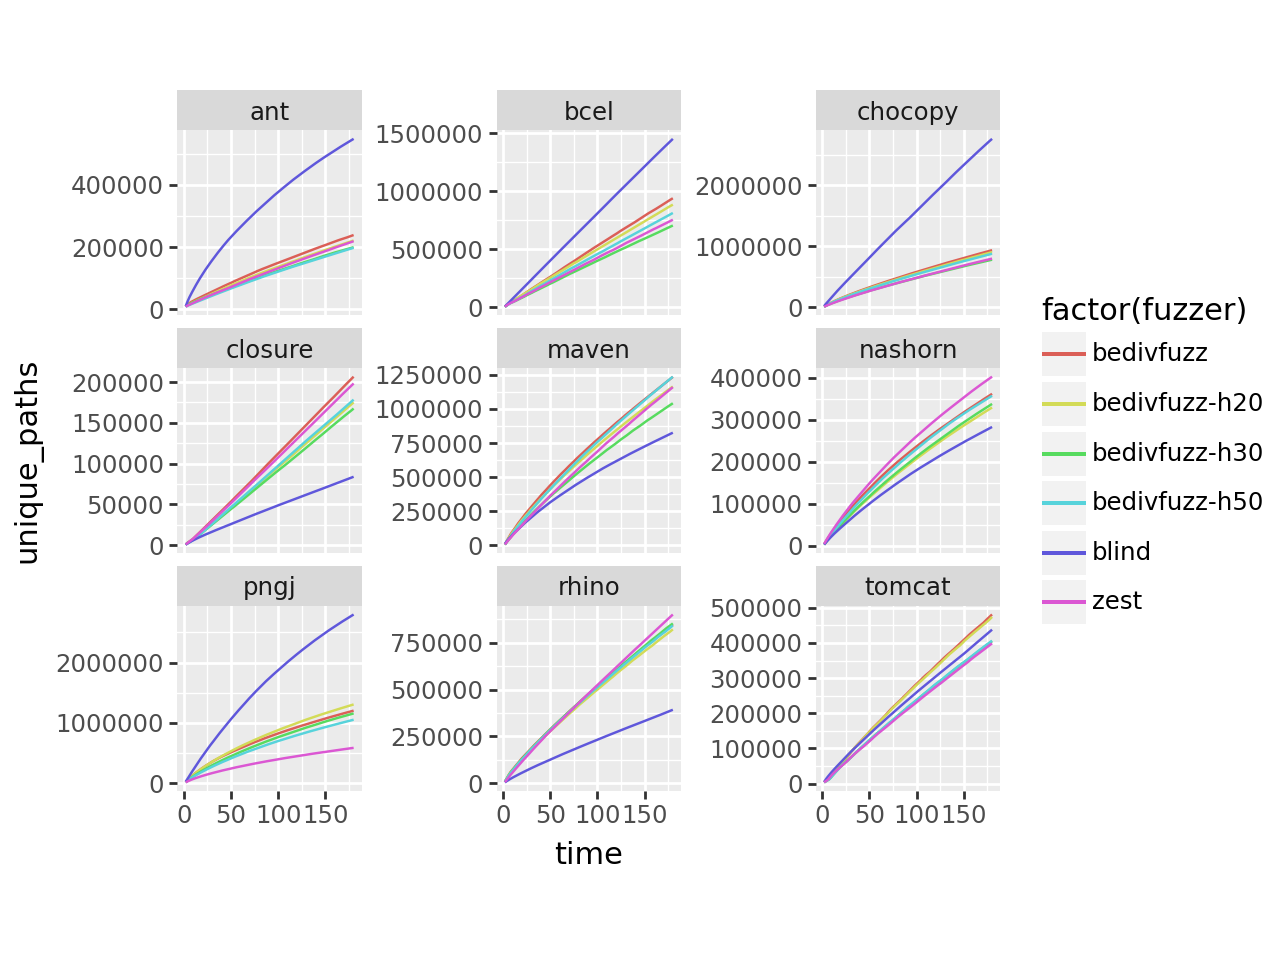

In [22]:
(ggplot(mean_trials.reset_index().query("time > 1"), aes("time", "unique_paths", color="factor(fuzzer)"))
 + geom_line()
 + facet_wrap("~subject", scales="free_y")
 + theme(aspect_ratio = 1.0)
)

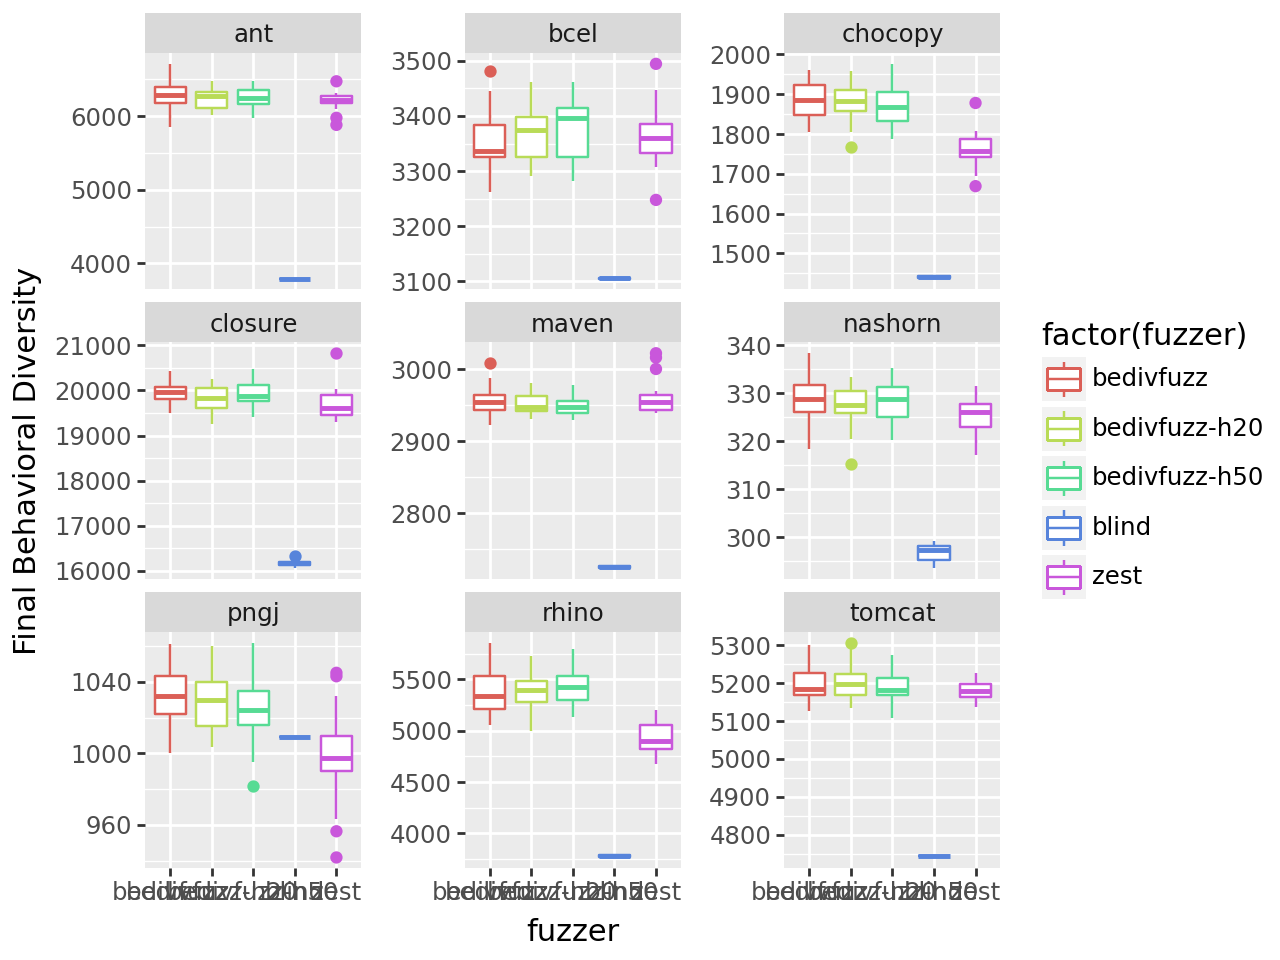

In [15]:
final_scores = trials.loc[trials['time'] == 180]

(ggplot(final_scores, aes("fuzzer", "b2", color="factor(fuzzer)"))
 + geom_boxplot()
 + facet_wrap("~subject", scales="free_y")
 + ylab("Final Behavioral Diversity")
)

In [31]:
trials.loc[trials['time'] == 180]

,fuzzer,subject,trial,time,b0,b1,b2
3585,zest,ant,1,180,10410.0,6693.30,6397.44
3585,zest,ant,2,180,10400.0,6730.58,6511.89
3586,zest,ant,3,180,10384.0,6550.98,6260.45
3586,zest,ant,4,180,10385.0,6506.47,6207.19
3566,zest,ant,5,180,11001.0,6554.19,6261.28
...,...,...,...,...,...,...,...
3605,bedivfuzz,tomcat,16,180,9396.0,6286.57,6085.37
3606,bedivfuzz,tomcat,17,180,9380.0,6301.22,6106.43
3603,bedivfuzz,tomcat,18,180,9406.0,6352.68,6146.13
3602,bedivfuzz,tomcat,19,180,9342.0,6344.74,6150.90


In [21]:
import scipy.stats as stats

In [54]:
metric = 'b2'
alpha = 0.01
time = 180
for s in subjects:
    x = trials.query(f"fuzzer == 'zest' and subject == '{s}' and time == {time}")[metric].to_numpy()
    y = trials.query(f"fuzzer == 'bedivfuzz' and subject == '{s}' and time == {time}")[metric].to_numpy()

    if stats.mannwhitneyu(x, y, alternative='two-sided').pvalue < alpha:
        print(f"{s.ljust(10)}: {'zest' if np.mean(x) > np.mean(y) else 'bedivfuzz'}")
    else:
        print(f"{s.ljust(10)}: not significant")


ant       : not significant
bcel      : not significant
chocopy   : bedivfuzz
closure   : bedivfuzz
maven     : not significant
nashorn   : not significant
pngj      : bedivfuzz
rhino     : bedivfuzz
tomcat    : not significant


In [16]:
import math

crash_to_id = {}
def deduplicate_crash(exception_class, stack_trace):
    key = (exception_class, '-'.join(str(stack_trace).split('-')[:3]))
    if str(exception_class) == 'nan' or "OutOfMemoryError" in str(exception_class):
        return -1
    if key in crash_to_id.keys():
        return crash_to_id[key]
    else:
        crash_id = len(crash_to_id)
        crash_to_id[key] = crash_id
        return crash_id

In [17]:
def crash_trial_df(fuzzer: str, subject: str, trial: int):
    df = pd.read_csv(
        os.path.join(results_base_dir, fuzzer, subject, f'trial-1', 'failure_info.csv'),
        skipinitialspace=True
    )

    df['trial'] = trial
    df['fuzzer'] = fuzzer
    df['subject'] = subject
    df['crash_id'] = df.apply(lambda row: deduplicate_crash(row['exception_class'], row['top5_stack_trace']), axis=1)

    return df[['fuzzer', 'subject', 'trial', '# ttd', 'exception_class', 'crash_id']]

In [18]:
crash_dfs = []
for f, s, t in itertools.product(fuzzers, subjects, range(1, num_trials+1)):
    crash_dfs.append(crash_trial_df(fuzzer=f, subject=s, trial=t))
crash_trials = pd.concat(crash_dfs)

In [19]:
crash_trials = crash_trials.loc[crash_trials['crash_id'] != -1]

In [20]:
crash_trials.groupby(['subject', 'fuzzer'])['# ttd'].agg('median').round(0).astype(int)

subject  fuzzer       
bcel     bedivfuzz        7580328
         bedivfuzz-h20    1220420
         bedivfuzz-h50    7206090
         zest              800566
closure  bedivfuzz        7630866
         bedivfuzz-h20      57702
         bedivfuzz-h50    4592754
         zest             8471268
nashorn  bedivfuzz        1163272
         bedivfuzz-h50    6277283
rhino    bedivfuzz        1888946
         bedivfuzz-h20    1691551
         bedivfuzz-h50    3849525
         blind            4846209
         zest             5335007
Name: # ttd, dtype: int64

In [38]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].agg('nunique')

subject  fuzzer   
bcel     bedivfuzz    2
         zest         1
closure  bedivfuzz    1
         zest         5
nashorn  bedivfuzz    1
rhino    bedivfuzz    3
         blind        3
         zest         2
Name: crash_id, dtype: int64

In [47]:
# Deduplicate bugs
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
    .groupby(['subject', 'fuzzer', 'crash_id']).agg('mean').round(0).astype(int)

subject  fuzzer     crash_id
bcel     bedivfuzz  0.0          4479866
                    8.0         10680791
         zest       0.0           362034
closure  bedivfuzz  1.0          7630866
         zest       1.0          6016744
                    2.0          7488077
                    3.0          8462959
                    4.0          8479578
                    5.0          8482134
nashorn  bedivfuzz  9.0            65294
rhino    bedivfuzz  6.0           165852
                    7.0           147598
                    10.0         1197785
         blind      6.0            27312
                    7.0           652218
                    11.0         5726879
         zest       6.0           111319
                    7.0           160450
Name: # ttd, dtype: int64

In [40]:
crash_to_id

{('class org.apache.bcel.verifier.exc.AssertionViolatedException',
  'java.base/jdk.internal.util.Preconditions.outOfBounds(Preconditions.java:64)-java.base/jdk.internal.util.Preconditions.outOfBoundsCheckIndex(Preconditions.java:70)-java.base/jdk.internal.util.Preconditions.checkIndex(Preconditions.java:248)'): 0,
 ('class java.lang.IllegalStateException',
  'com.google.javascript.jscomp.jarjar.com.google.common.base.Preconditions.checkState(Preconditions.java:590)-com.google.javascript.jscomp.LightweightMessageFormatter.padMultipleLines(LightweightMessageFormatter.java:237)-com.google.javascript.jscomp.LightweightMessageFormatter.getExcerptWithPosition(LightweightMessageFormatter.java:169)'): 1,
 ('class java.lang.RuntimeException',
  'com.google.javascript.jscomp.jarjar.com.google.common.base.Preconditions.checkState(Preconditions.java:502)-com.google.javascript.jscomp.InlineVariables$InliningBehavior.removeDeclaration(InlineVariables.java:816)-com.google.javascript.jscomp.InlineVar

In [41]:
crash_trials.groupby(['subject', 'fuzzer'])['crash_id'].unique()

subject  fuzzer   
bcel     bedivfuzz                   [0.0, 8.0]
         zest                             [0.0]
closure  bedivfuzz                        [1.0]
         zest         [1.0, 2.0, 3.0, 4.0, 5.0]
nashorn  bedivfuzz                        [9.0]
rhino    bedivfuzz             [7.0, 6.0, 10.0]
         blind                 [6.0, 7.0, 11.0]
         zest                        [6.0, 7.0]
Name: crash_id, dtype: object

In [42]:
crash_trials.groupby(['subject', 'fuzzer', 'trial', 'crash_id'])['# ttd'].agg('min')\
   .groupby(['subject', 'fuzzer', 'crash_id']).agg('count')

subject  fuzzer     crash_id
bcel     bedivfuzz  0.0         20
                    8.0         20
         zest       0.0         20
closure  bedivfuzz  1.0         20
         zest       1.0         20
                    2.0         20
                    3.0         20
                    4.0         20
                    5.0         20
nashorn  bedivfuzz  9.0         20
rhino    bedivfuzz  6.0         20
                    7.0         20
                    10.0        20
         blind      6.0         20
                    7.0         20
                    11.0        20
         zest       6.0         20
                    7.0         20
Name: # ttd, dtype: int64